<a href="https://colab.research.google.com/github/seanigens/Cloud-Computing/blob/main/Cloud_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
from plotnine import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dp1y2021_path = "/content/drive/My Drive/Cloud assignment 1/DP1Y2021_PercentOnly_Updated.xlsx"
dp1y2021_df = pd.read_excel(dp1y2021_path)

In [ ]:
congressional_district_path = "/content/drive/My Drive/Cloud assignment 1/congressional_district_with_parties.csv"
congressional_district_df = pd.read_csv(congressional_district_path)

In [ ]:
#Getting the state and district number
def extract_state_district_v2(column_name):
    match = re.search(r'Congressional District (\d+|\w+) \(\d+\w+\w Congress\), ([\w\s]+)\!\!Percent', column_name)
    if match:
        district = match.group(1)
        state = match.group(2).strip()
        return state, district
    return None, None

#Creating a mapping of columns to state and district numbers
state_district_mapping = {col: extract_state_district_v2(col) for col in dp1y2021_df.columns if "!!Percent" in col}

#Mapping df
state_district_df = pd.DataFrame(state_district_mapping.items(), columns=['Column Name', 'State and District'])
state_district_df['State'] = state_district_df['State and District'].apply(lambda x: x[0])
state_district_df['District Number'] = state_district_df['State and District'].apply(lambda x: x[1])

#Reshaping dp1y2021_df
reshaped_dp1y2021_df = pd.DataFrame()
state_district_to_column = state_district_df.set_index(['State', 'District Number'])['Column Name'].to_dict()

for (state, district), column_name in state_district_to_column.items():
    district_data = dp1y2021_df[['Label (Grouping)', column_name]].set_index('Label (Grouping)').transpose()
    district_data.index = [f"{state}_District_{district}"]
    reshaped_dp1y2021_df = pd.concat([reshaped_dp1y2021_df, district_data])

#Merge
congressional_district_df['State_District'] = congressional_district_df['State'] + "_District_" + congressional_district_df['district number'].astype(str)
merged_df = congressional_district_df.merge(reshaped_dp1y2021_df, left_on='State_District', right_index=True, how='left')

In [ ]:
#Save df as excel file to look at data
merged_output_file_path = '/content/drive/My Drive/Cloud assignment 1/Merged_Congressional_Districts.xlsx'
merged_df.to_excel(merged_output_file_path, index=False)

/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


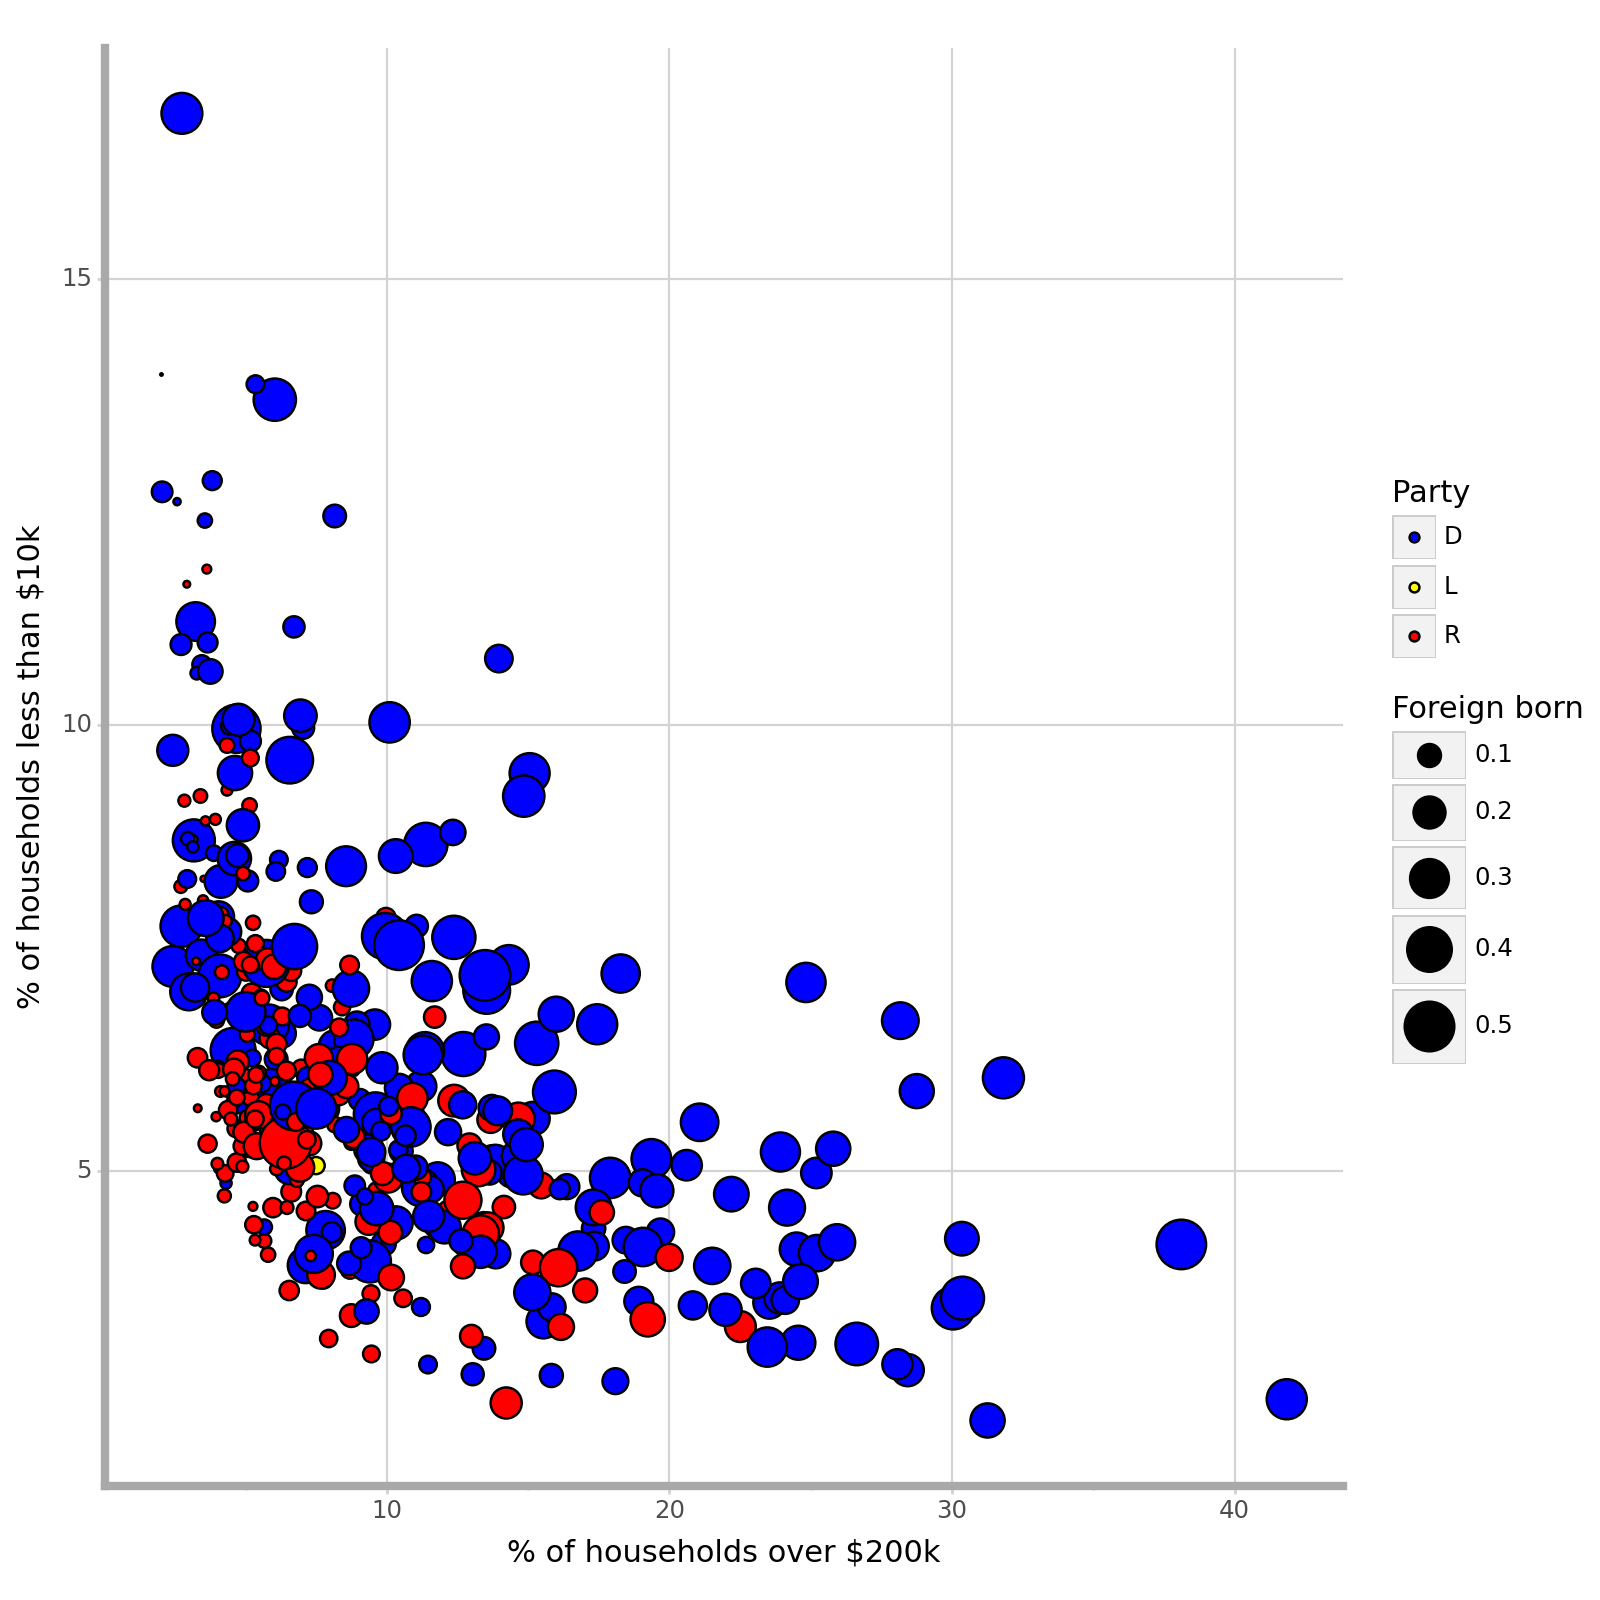

<Figure Size: (800 x 800)>

In [ ]:
merged_df2 = merged_df.rename(columns=lambda x: x.strip())
(ggplot(merged_df2) +
     theme_bw() +
     geom_point(aes(x='% of households over $200k', y='% of households less than $10k', fill = 'Party', size = 'Foreign born')) +
     scale_fill_manual(values=['blue','yellow','red']) +
     theme(
         figure_size = (8,8),
         line = element_line(color = 'lightgrey'),
         panel_grid_minor_x = element_blank(),
         panel_grid_minor_y = element_blank(),
         axis_line=element_line(size=3, color = 'darkgrey'),
         panel_border = element_blank()
         ) +
     scale_size(range=(0,10))
)